## Analysis for Week 2: Mac Hand Data Project

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_individual_and_hand_cols(df):
    df = df.copy()
    df['individual_id'] = df['subject_id'].str[:-2]
    df['hand'] = df['subject_id'].str[-1]
    return df

def get_iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

In [13]:
#Importing data
data = pd.read_csv('./Data/MacHandData.csv')

#Cleaning Dataframe
data.columns = data.columns.str.lower().str.replace(' ', '_')
data

,subject_id,dominance,affected_side,age,sex,task1,total_score
0,001H-L,0,0,52,0,5,97
1,001H-L,0,0,52,0,5,99
2,001H-R,0,0,52,0,4,82
3,001H-R,0,0,52,0,4,80
4,002H-L,1,1,47,0,4,58
...,...,...,...,...,...,...,...
194,042N-L,0,1,31,0,4,89
195,042N-L,0,1,31,0,4,88
196,042N-L,0,1,31,0,4,89
197,042N-R,0,1,31,0,5,99


### Summary statistics by individual

Gets number of trials for each participant, per hand.

In [14]:
trial_counts_df = get_individual_and_hand_cols(data)\
    .groupby(['individual_id', 'hand'])\
    .size()\
    .reset_index(name='counts')

trial_counts_df

,individual_id,hand,counts
0,001H,L,2
1,001H,R,2
2,002H,L,2
3,002H,R,2
4,003H,L,3
...,...,...,...
79,040N,R,2
80,041N,L,3
81,041N,R,2
82,042N,L,3


We see below that all participants perform the task at least once with both hands.

In [15]:
trial_counts_summary = trial_counts_df.groupby('individual_id').size().reset_index(name='num_hands')
filtered_counts = trial_counts_summary[trial_counts_summary['num_hands'] != 2]

filtered_counts.count()

individual_id    0
num_hands        0
dtype: int64

Descriptive stats on task completion:

In [16]:

df_right = df2[df2['hand'] == 'R']
df_left = df2[df2['hand'] == 'L']


print(f'Participants perform the task with their right hand a median of {df_right["counts"].median()} times, with an IQR of {get_iqr(df_right["counts"])} times.')
print(f'Participants perform the task with their left hand a median of {df_left["counts"].median()} times, with an IQR of {get_iqr(df_left["counts"])} times.')

NameError: name 'df2' is not defined

### Descriptive stats on dominance and affected side

Reported stats are on the level of the individual, not on the level of the trial. This is important since different individuals sometimes perform different numbers of trials.

In [ ]:
das_by_individual = get_individual_and_hand_cols(data)\
    .groupby(['individual_id'])\
    .agg({'dominance': 'first', 'affected_side': 'first'})\
    .reset_index()

df = das_by_individual.groupby(['dominance', 'affected_side'])\
    .agg({'individual_id': 'count'})\
    .rename(columns={'individual_id': 'count'})\
    .reset_index()

df['proportion'] = df['count'] / df['count'].sum()

df_labelled = df
df_labelled.columns

df_labelled['dominance'] = df_labelled['dominance'].map(lambda x: 'Right' if x == 0 else 'Left')
df_labelled['affected_side'] = df_labelled['affected_side'].map(lambda x: 'Right' if x == 0 else ('Left' if x == 1 else 'Both'))

df_labelled

df_summary = df_labelled

df_summary['affected_side_dominance'] = df_summary.apply(lambda row: 'Dominant' if row['dominance'] == row['affected_side']\
            else ('Both Affected' if row['affected_side'] == 'Both' else 'Non-dominant'), axis=1)

df_summary = df_summary.groupby('affected_side_dominance').agg({'count': 'sum', 'proportion': 'sum'}).reset_index()
df_summary


,affected_side_dominance,count,proportion
0,Both Affected,1,0.02381
1,Dominant,20,0.47619
2,Non-dominant,21,0.50000


There are 20 participants whose dominant hand was affected, 21 participants whose non-dominant hand was affected, and one participant for whom both hands were affected by traumatic injury.

50.0


<Axes: >

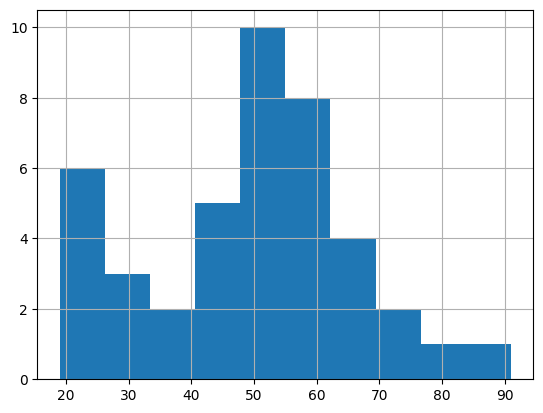

In [ ]:
ages = get_individual_and_hand_cols(data)\
    .groupby('individual_id').agg({'age': 'first'}).reset_index()
median_age = ages['age'].median()
print(median_age)

ages['age'].hist()

In [ ]:
sexes = get_individual_and_hand_cols(data)\
    .groupby('individual_id').agg({'sex': 'first'}).reset_index()
pivot = sexes.pivot_table(index=['sex'],
                       values=['sex'],
                       aggfunc='count')
print(pivot)

     individual_id
sex               
0               26
1               16


In [27]:
total_scores = get_individual_and_hand_cols(data)\
    .query('total_score<=100')\
    .groupby(['dominance', 'affected_side'])\
    .agg({'total_score': ['mean', 'std']}).reset_index
print(total_scores)

<bound method DataFrame.reset_index of                         total_score           
                               mean        std
dominance affected_side                       
0         0               89.152941  11.190457
          1               81.752809  21.390461
1         0               88.000000   8.923284
          1               76.000000  19.131126>
